In [10]:
import pandas as pd
import numpy as np
#from workalendar.usa import Illinois
from sklearn.cluster import *

In [33]:
#calendar = Illinois() 

from sklearn import preprocessing
import matplotlib.patches as mpatches
from sklearn.cluster import *

n_clusters = 50

def feature_selection(initial_csv):
    columns_to_use = ['Date', 'Longitude', 'Latitude']
    data = pd.read_csv(initial_csv, sep=',', encoding='utf8', usecols=columns_to_use)
    return data

def date_decompose(df):
    df = df.copy()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Hour'] = df['Date'].dt.hour
    df['Weekday'] = df['Date'].dt.weekday
    ## Adding day off informations does not seem to be useful eventually
    #df['Weekend'] = (df['Weekday'] < 5).astype(int) ## not pretty effective
    #df['Holiday'] = df['Date'].apply(lambda x: int(calendar.is_holiday(x))) ## same
    return df

def feature_engineering(df):
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
    df = df.dropna()
    df = date_decompose(df)
    df['Crimes'] = 1
    coordX = df['Longitude']
    coordY = df['Latitude']
    coords = pd.concat([coordX, coordY],axis=1).as_matrix()
    ## The mini batch KMeans is appropriate here as it stays time efficient even for huge dataset
    modCluster = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, batch_size=100, verbose=0, compute_labels=True,
                                 random_state=None, tol=0.0, max_no_improvement=10, init_size=None, n_init=3, reassignment_ratio=0.01)
    print('begin clustering...')
    labels = modCluster.fit_predict(coords)
    coordsClusters = np.column_stack((coords, labels))
    print('done clustering...')
    
    ClustCenters = pd.DataFrame(modelCluster.cluster_centers_) 
    ClustCenters['Cluster'] = ClustCenters.index
    ClustCenters.columns = ['Center_lon', 'Center_lat', 'Cluster']
        
    df['Cluster'] = labels
    df = df[['Year', 'Month', 'Day', 'Weekday', 'Hour', 'Cluster', 'Crimes']]
    df = df.groupby(['Year', 'Month', 'Day', 'Weekday', 'Hour', 'Cluster']).sum().reset_index()
    
    years = df['Year']
    months = df['Month']
    days = df['Day']
    weekday = df['Weekday']
    hours = df['Hour']
    cluster = df['Cluster']
    crimes = df['Crimes']
    
    df = pd.concat([years, months, days, weekday, hours, cluster, crimes], axis=1)
        
    ## Two years of data, from 2008 to 2009 included
    #df = df.query('Year >= 2008 and Year <= 2009')
    ## One year of data, 2008
    df = df.query('Year == 2008')
        
    return ClustCenters, coordsClusters, df

inputfile = 'Crimes_-_2008_to_present.csv' ## Full crime dataset from 2008

dataSelected = feature_selection(inputfile)
print("done data selection...")
ClustCenters, coordsClusters, dataTransformed = feature_engineering(dataSelected)
print("done all of feature engineering...")


done data selection...
begin clustering...
done clustering...
done all of feature engineering...


In [35]:
dataTransformedx = dataTransformed.merge(ClustCenters, on = ['Cluster'], how = 'left')
dataTransformedx.head()

,Year,Month,Day,Weekday,Hour,Cluster,Crimes,Center_lon,Center_lat
0,2008,1,1,1,0,0,9,-87.787443,41.932761
1,2008,1,1,1,0,1,6,-87.675496,41.826316
2,2008,1,1,1,0,2,5,-87.581493,41.766981
3,2008,1,1,1,0,3,6,-87.660667,41.943725
4,2008,1,1,1,0,4,2,-87.633733,41.739359


In [36]:
# Hardship Index information

xtrafile = 'chi_se_2008_2012.csv'

xcolumns_to_use = ['Community Area Number', 'Latitude', 'Longitude', 'HARDSHIP INDEX'] 
xdata = pd.read_csv(xtrafile, sep=',', encoding='utf8', usecols=xcolumns_to_use)
xdata.columns = ['CAN', 'CA_lat', 'CA_lon', 'HI']

xdata.head()

,CAN,CA_lat,CA_lon,HI
0,1,42.010529,-87.687114,39
1,2,42.001340,-87.710225,46
2,3,41.966138,-87.670147,20
3,4,41.969948,-87.693354,17
4,5,41.946919,-87.702608,6


In [37]:
# Haversine formula to compute distance between latitudes and longitudes, results in distance in kilometers

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [42]:
# Calculate distance between centers of each cluster and each community area and assign based on minimum distance

D = {}
for x in range(0,50):
    for y in range(0,77):
        d=haversine(dataTransformedx.Center_lon[x], dataTransformedx.Center_lat[x], xdata.CA_lon[y], xdata.CA_lat[y])
        
        if y == 0:
            D[x]= [y,d]
        elif d<D[x][1]:
            D[x]=[y,d]

In [43]:
# View assignments in dictionary
D

{0: [18, 0.7742860999788661],
 1: [58, 0.6699098392434374],
 2: [42, 0.49083470022154957],
 3: [5, 2.2749737906565652],
 4: [43, 0.2823399384746541],
 5: [67, 0.43099611346667704],
 6: [54, 3.9897677317044455],
 7: [25, 0.7575449266639822],
 8: [23, 2.04687885304054],
 9: [40, 1.6582791054089845],
 10: [61, 0.44138523032761257],
 11: [0, 1.2920055419348129],
 12: [53, 1.5792908609713343],
 13: [28, 0.8215668359625298],
 14: [66, 1.651600032071606],
 15: [20, 0.6480136551872288],
 16: [75, 3.4660193345025636],
 17: [31, 0.6196609775525054],
 18: [26, 1.2818474521259067],
 19: [45, 1.5208449308735434],
 20: [49, 0.7676486892465694],
 21: [3, 0.2786296328656309],
 22: [25, 2.3223640856724166],
 23: [62, 0.9783826735101647],
 24: [31, 1.5919216957516993],
 25: [69, 0.6079727697398011],
 26: [63, 1.017653751602854],
 27: [34, 1.0793450668943272],
 28: [10, 1.8909688843974075],
 29: [2, 1.2105371123391409],
 30: [30, 1.9206360874373043],
 31: [47, 0.7410642726669141],
 32: [68, 0.51620216272

In [45]:
# Add hardship index to cluster, community area in dataframe
clustdf = pd.DataFrame(np.arange(0,50))
clustdf.columns = ['Cluster']
clustdf['CAN']= clustdf['Cluster'].apply(lambda x: D[x][0])
clustdf = clustdf.merge(xdata, on = ['CAN'], how = 'left')
clustdf = clustdf.drop(['CA_lat', 'CA_lon'], axis=1)
clustdf.tail()

,Cluster,CAN,HI
45,45,1,39.0
46,46,6,5.0
47,47,68,94.0
48,48,41,14.0
49,49,18,50.0


In [46]:
# Merge with dataTransformed

dataTransformedz = dataTransformedx.merge(clustdf, on = ['Cluster'], how = 'left')
dataTransformedz.head()

,Year,Month,Day,Weekday,Hour,Cluster,Crimes,Center_lon,Center_lat,CAN,HI
0,2008,1,1,1,0,0,9,-87.787443,41.932761,18,50.0
1,2008,1,1,1,0,1,6,-87.675496,41.826316,58,84.0
2,2008,1,1,1,0,2,5,-87.581493,41.766981,42,58.0
3,2008,1,1,1,0,3,6,-87.660667,41.943725,5,6.0
4,2008,1,1,1,0,4,2,-87.633733,41.739359,43,55.0


In [49]:
dataTransformed = dataTransformedz

In [50]:
from datetime import datetime
from datetime import timedelta
from datetime import date
import math

""" 
    The goal here is to generate new rows matching (date, location) couples for which no crime occured. 
    In order to do so, we have to consider all (date, location) couples in a given range of dates 
    (all dates between the first and last chosen dates) 
"""

years = dataTransformed['Year'].values
years = np.reshape(years, (len(years), 1))
months = pd.get_dummies(dataTransformed['Month']).values
days = dataTransformed['Day'].values
days = np.reshape(days, (len(days), 1))
weekdays = pd.get_dummies(dataTransformed['Weekday']).values
hours = dataTransformed['Hour'].values
hours = np.reshape(hours, (len(hours), 1))
clusters = pd.get_dummies(dataTransformed['Cluster']).values
crimes = dataTransformed['Crimes'].values
crimes = np.reshape(crimes, (len(crimes), 1))
hardship_index = dataTransformed['HI'].values
hardship_index = np.reshape(crimes, (len(hardship_index), 1))

hours_clusters_crimes = np.concatenate((years, months, days, weekdays, hours, clusters, crimes, hardship_index), axis=1)

date_begin = dataTransformed.head(1).ix[:, :3].values[0]
date_end = dataTransformed.tail(1).ix[:, :3].values[0]

date_begin_dt = datetime(date_begin[0], date_begin[1], date_begin[2])
date_end_dt = datetime(date_end[0], date_end[1], date_end[2])

diff = date_end_dt - date_begin_dt
theorical_size = (diff.days + 1) * n_clusters * 24

next_hour = n_clusters
next_day = 24 * n_clusters
next_week = 24 * n_clusters * 7

date_cursor = date_begin_dt
mat = []
compt_hours = 0
for i in range(theorical_size + next_week):
    if i%n_clusters == 0 and i != 0:
        date_cursor += timedelta(hours=1)
    
    tok_clusters = i % n_clusters
      
    year = date_cursor.year  
    month = [0.]*(date_cursor.month -1) + [1.] + [0.]*(12 - date_cursor.month)
    day = date_cursor.day
    weekday = [0.]*date_cursor.weekday() + [1.] + [0.]*(7-date_cursor.weekday()-1)
    hour = date_cursor.hour
    vec_cluster = [0.]*tok_clusters + [1.] + [0.]*(n_clusters-tok_clusters-1)
    
    mat.append(np.asarray([year] + month + [day] + weekday + [hour] + vec_cluster + [0.]))
    
mat = np.asarray(mat)

train_set = mat[:-next_week, :]
test_set_1h = mat[-next_hour:, :-1]
test_set_1d = mat[-next_day:, :-1]
test_set_1w = mat[-next_week:, :-1]

index = []
compt = 0

for i in range(len(train_set)):
    if np.array_equal(train_set[i, :-1], hours_clusters_crimes[compt, :-1]):
        index.append([i, hours_clusters_crimes[compt, -1]])
        compt += 1
        if compt == len(hours_clusters_crimes):
            break
    else:
        pass
    if i % 100000 == 0:
        state = float(i) / len(train_set) * 100.
        print("{0:.2f}".format(state) + '%')

for i in range(len(index)):
    train_set[index[i][0], -1] = index[i][1]

0.00%
22.77%
45.54%
68.31%
91.07%


In [4]:
outputfile = 'data/complete_grouped_crimes.csv'
pd.DataFrame(train_set).to_csv(outputfile, sep=';', mode='w', encoding='utf8', index=False)

In [5]:
import numpy as np
import platform
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

def model(X, y):
    print('Training the model..')
            
    reg = Pipeline([
            ('rfr', RFR(n_estimators=30, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
             max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, 
             verbose=0, warm_start=False))
            ]) 
    reg.fit(X, y)
    print('Done training the model..')       
    return reg
    
def predict(X, reg):    
    y_pred = reg.predict(X)         
    return y_pred

def parse_file(file):
    X = []
    y = []
    with open(file, 'r') as data:
        data.readline()
        for line in data:
            row = line.split(';')
            for i in range(len(row)):
                row[i] = float(row[i])
            X.append(row[:len(row)-1])
            y.append(row[len(row)-1])
    return X, y

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.preprocessing import StandardScaler
from datetime import *
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVC 
        
def crossValidationError(file='data/complete_grouped_crimes.csv'):
    p_unlabelled = 0.2
    X, y = parse_file(file)   
    print("Done parsing..")
    X = np.asarray(X)
    Y = np.asarray(y)
    Y = Y.reshape(len(Y),1)
    
    X_lab, X_unlab, y_lab, y_unlab = train_test_split(X, Y, test_size=p_unlabelled, random_state=57)
    print("Done splitting labeled/unlabeled ones..")
    
    mod = model(X_lab, y_lab)
    print('Done training..')
    
    yPred = predict(X_unlab, mod)
    
    mseError = mean_squared_error(y_unlab, yPred)
    return mod, mseError

if __name__ == '__main__':
    mod, crossvalidationError = crossValidationError()
    print('--------------------------') 
    print('Mean Squared Error = ' + str(crossvalidationError))
    print('--------------------------') 

Done parsing..
Done splitting labeled/unlabeled ones..
Training the model..


C:\Users\comea\Anaconda2\lib\site-packages\sklearn\pipeline.py:270: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Done training the model..
Done training..
--------------------------
Mean Squared Error = 1.1973099322
--------------------------


In [7]:
""" Predicting crimes quantities, in each cluster, for several temporal ranges: 1 hour, 1 day, and 1 week """

next_hour = n_clusters
next_day = 24 * n_clusters
next_week = 24 * n_clusters * 7

test_set_1h = mat[-next_hour:, :-1]
test_set_1d = mat[-next_day:, :-1]
test_set_1w = mat[-next_week:, :-1]

clusters_1h = test_set_1h[:, -n_clusters:]
clusters_1d = test_set_1d[:, -n_clusters:]
clusters_1w = test_set_1w[:, -n_clusters:]

undummied_cluster_1h = []
for row in clusters_1h:
    undummied_cluster_1h.append(np.where(row==1)[0])
undummied_cluster_1h = np.asarray(undummied_cluster_1h)   

undummied_cluster_1d = []
for row in clusters_1d:
    undummied_cluster_1d.append(np.where(row==1)[0])
undummied_cluster_1d = np.asarray(undummied_cluster_1d)   

undummied_cluster_1w = []
for row in clusters_1w:
    undummied_cluster_1w.append(np.where(row==1)[0])
undummied_cluster_1w = np.asarray(undummied_cluster_1w) 

crimes_1h = predict(test_set_1h, mod)
crimes_1d = predict(test_set_1d, mod)
crimes_1w = predict(test_set_1w, mod)

prediction_1h = np.column_stack((undummied_cluster_1h, crimes_1h))
prediction_1d = np.column_stack((undummied_cluster_1d, crimes_1d))
prediction_1w = np.column_stack((undummied_cluster_1w, crimes_1w))

prediction_1h_dt = pd.DataFrame(prediction_1h).groupby(0).sum()
prediction_1d_dt = pd.DataFrame(prediction_1d).groupby(0).sum()
prediction_1w_dt = pd.DataFrame(prediction_1w).groupby(0).sum()


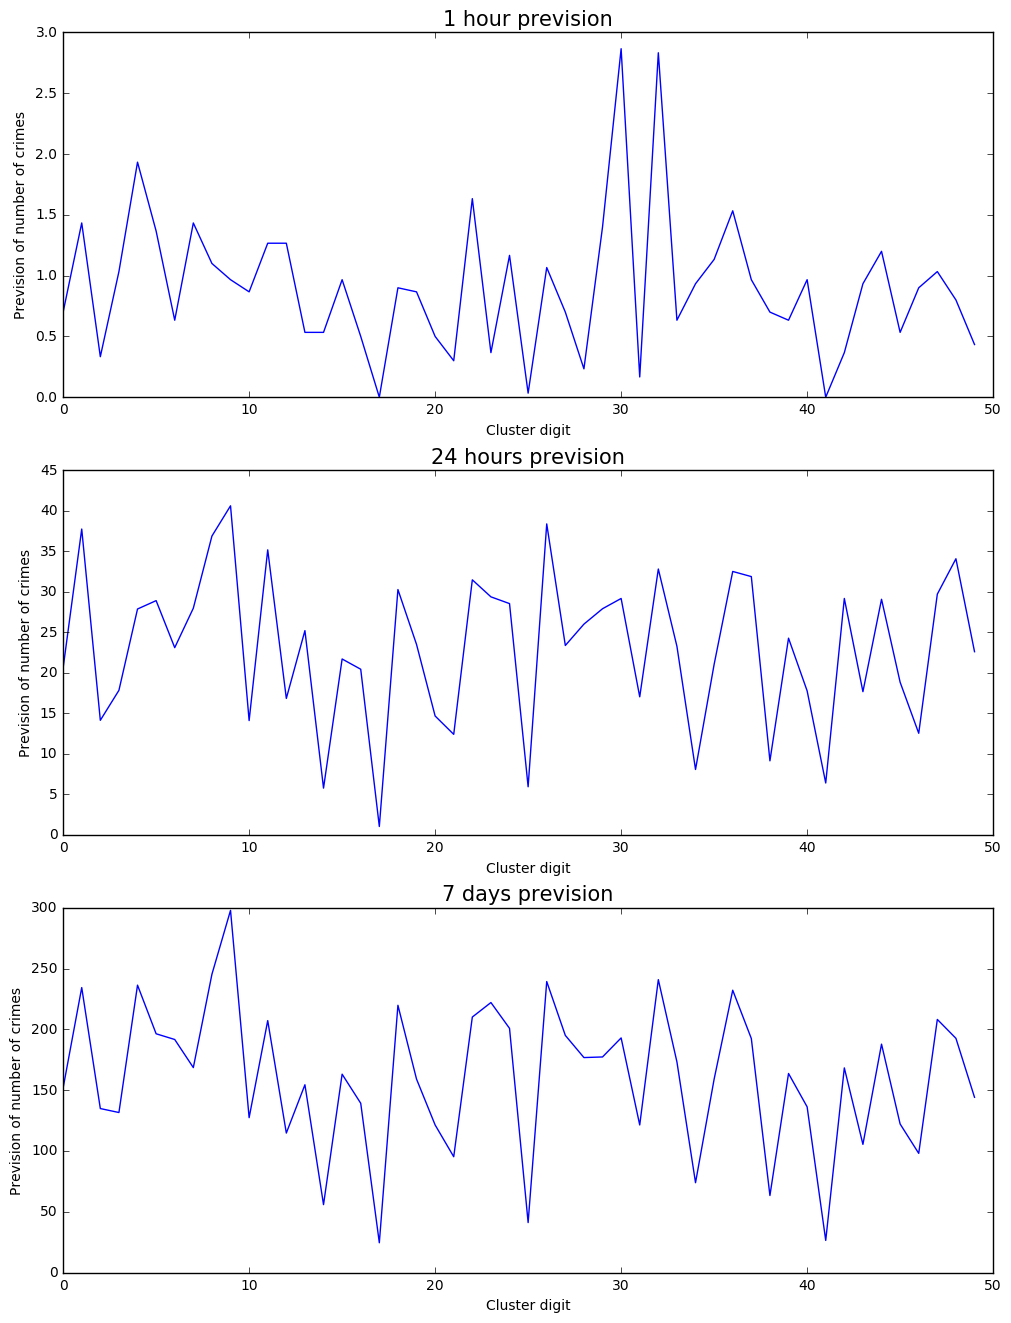

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

trend1 = prediction_1h_dt.as_matrix()
trend2 = prediction_1d_dt.as_matrix()
trend3 = prediction_1w_dt.as_matrix()

plt.rcParams['figure.figsize'] = (12.0, 16.0)

plt.figure(1)
plt.subplot(311)
plt.title('1 hour prevision', fontsize = 15)
plt.xlabel('Cluster digit')
plt.ylabel('Prevision of number of crimes')
plt.plot(range(n_clusters), trend1)
plt.subplot(312)
plt.title('24 hours prevision', fontsize = 15)
plt.xlabel('Cluster digit')
plt.ylabel('Prevision of number of crimes')
plt.plot(range(n_clusters), trend2)
plt.subplot(313)
plt.title('7 days prevision', fontsize = 15)
plt.xlabel('Cluster digit')
plt.ylabel('Prevision of number of crimes')
plt.plot(range(n_clusters), trend3)

In [9]:
plt.rcParams['figure.figsize'] = (12.0, 10.5)

## Scaling the crimes quantities between 0 and 1
scaling_trend1 = trend1 - trend1.min()
scaling_trend1 /= (scaling_trend1.max() - scaling_trend1.min())

scaling_trend2 = trend2 - trend2.min()
scaling_trend2 /= (scaling_trend2.max() - scaling_trend2.min())

scaling_trend3 = trend3 - trend3.min()
scaling_trend3 /= (scaling_trend3.max() - scaling_trend3.min())


mat = []

## The couples (coord, cluster) are reused here to be able to place of the maps the clusters locations
for i in range(len(coordsClusters)):
    ## Just to remove inconsistent coordinates
    if coordsClusters[i, 0] >= 1000 and coordsClusters[i, 1] >= 1000:
        mat.append(np.asarray([
            coordsClusters[i, 0], coordsClusters[i, 1], 
            scaling_trend1[int(coordsClusters[i, -1])], 
            scaling_trend2[int(coordsClusters[i, -1])], 
            scaling_trend3[int(coordsClusters[i, -1])]
        ]))
mat = np.asarray(mat)   

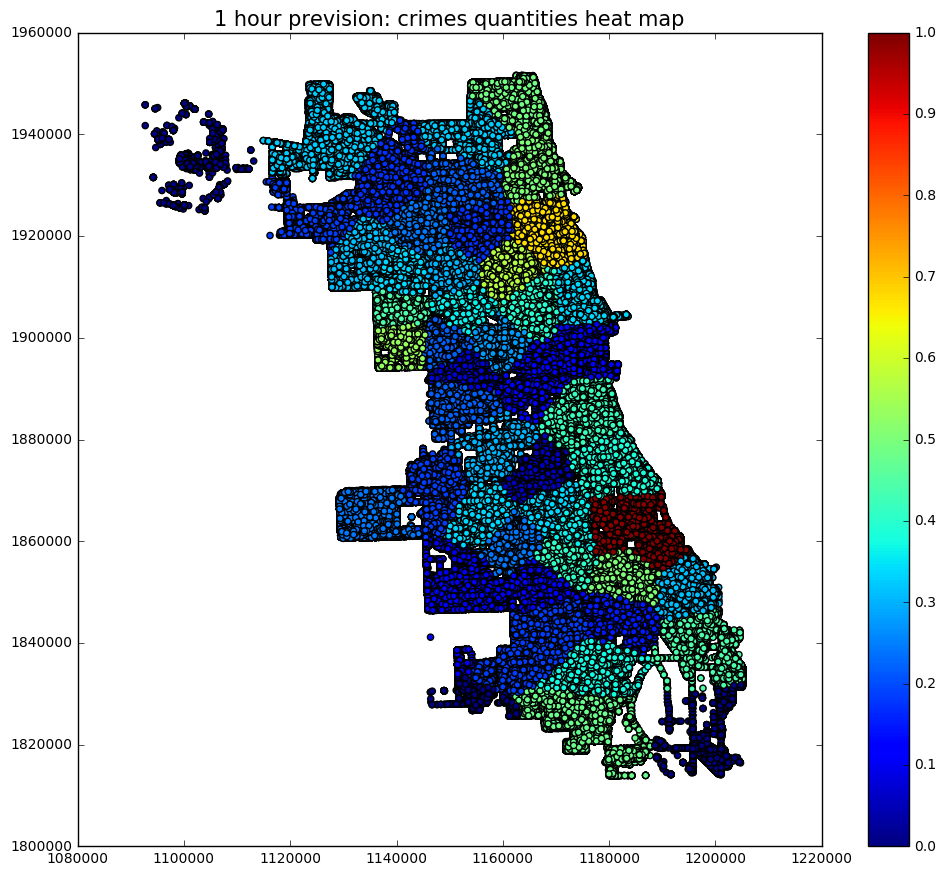

In [10]:
plt.scatter(mat[:, 0], mat[:, 1], c=mat[:, -3])
plt.colorbar()
plt.title("1 hour prevision: crimes quantities heat map", fontsize = 15)

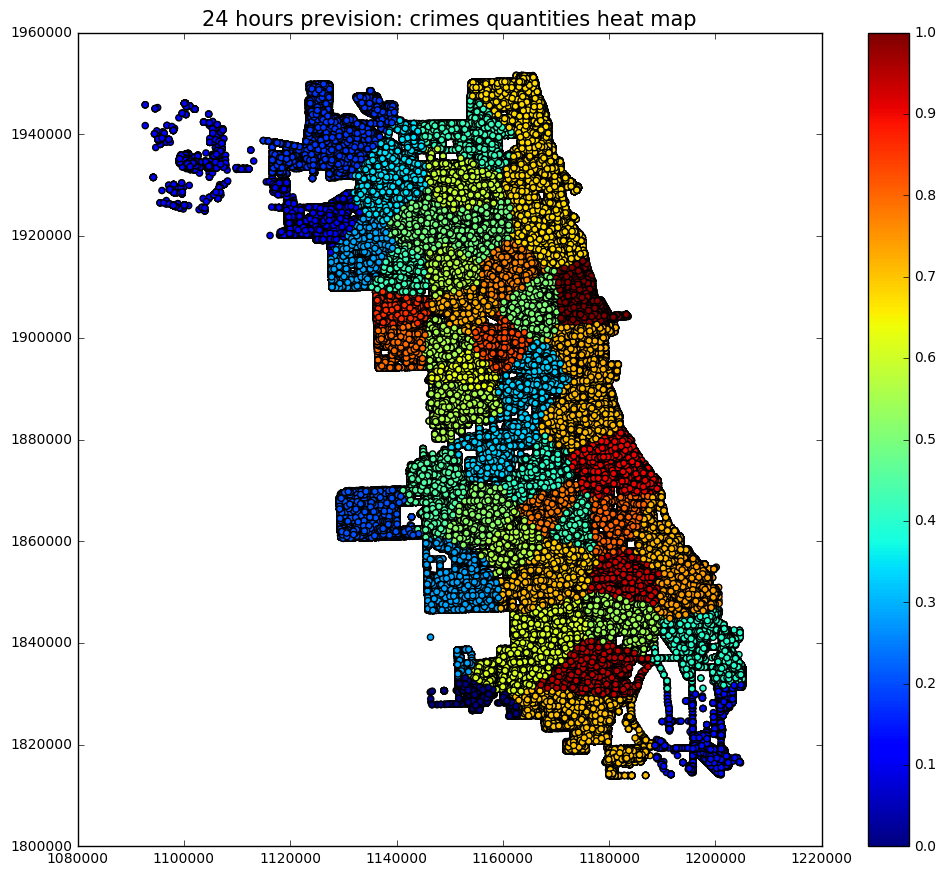

In [11]:
plt.scatter(mat[:, 0], mat[:, 1], c=mat[:, -2])
plt.colorbar()
plt.title("24 hours prevision: crimes quantities heat map", fontsize = 15)

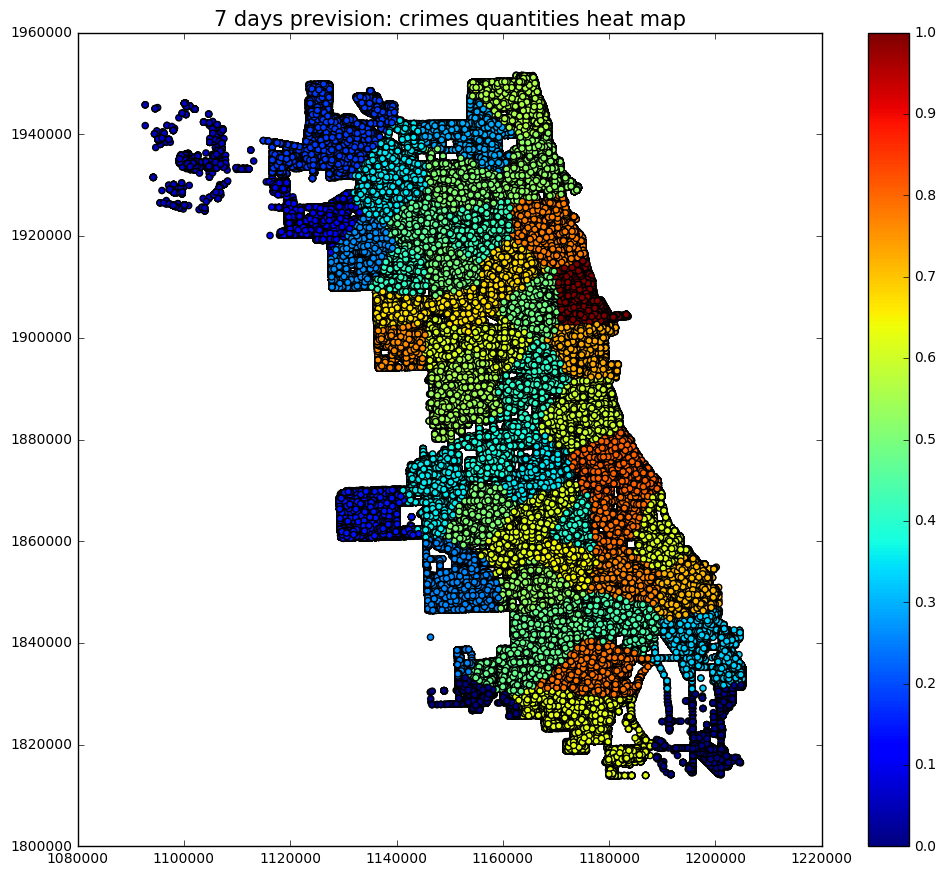

In [12]:
plt.scatter(mat[:, 0], mat[:, 1], c=mat[:, -1])
plt.colorbar()
plt.title("7 days prevision: crimes quantities heat map", fontsize = 15)